In [5]:
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

import pandas as pd
import numpy as np
from util import get_device, clean_df, texts_to_tensor

import re
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split

from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
df = pd.read_csv('geo-reviews-dataset-2023.csv')
df['name_ru'] = df['name_ru'].fillna('нет')
df = df[df['text'].str.len() >= 10]

In [12]:
def clean_address(address):
    # Замена слешей, не связанных с цифрами, на пробелы
    address = re.sub(r"(?<!\d)/|(?!\d)/", " ", address)
    # Удаление лишних пробелов
    address = re.sub(r"\s+", " ", address)

    return address

def clean_text(text):
    # Замена переносов строк пробелами
    text = re.sub(r"[\\n\\r]+", " ", text)

    # Удалить HTML-теги
    text = re.sub(r"<[^>]+>", "", text)

    # Удалить специальные символы
    text = re.sub(r"[^\w\s,.!?()]+", "", text)

    return text

In [13]:
df_cleaned = df.copy()
df_cleaned = clean_df(df_cleaned)

df_cleaned = df_cleaned[df_cleaned['rating'] > 0]

df_cleaned['text'] = df_cleaned['text'].apply(clean_text)
df_cleaned['address'] = df_cleaned['address'].apply(clean_address)
df_cleaned['name_ru'] = df_cleaned['name_ru'].str.strip()
df_cleaned['rubrics'] = df_cleaned['rubrics'].str.strip().str.lower()

In [7]:
MODEL_PATH = 'data/lstm-model/'  # каталог модели
OUTPUT_MODEL_NAME = "bilstm_bow_generator_model.pth" # имя модели после обучения

In [24]:
df_X = df_cleaned[:20000].copy()

df_X['input_text'] = df_cleaned.apply(
    lambda
        row: f"<name_ru> {row['name_ru']} <rubrics> {row['rubrics']} <rating> {row['rating']} <address> {row['address']} <text> {row['text']}",
    axis=1,
)

In [25]:
text = ' '.join(df_X['input_text'])

words = text.split()
word_counts = Counter(words)

vocab = list(word_counts.keys())
vocab_size = len(vocab)
word_to_int = {word: i for i, word in enumerate(vocab)}
int_to_word = {i: word for word, i in word_to_int.items()}

In [26]:
vocab_size

149545

In [27]:
SEQUENCE_LENGTH = 10

def get_samples(tokens):
    return [tokens[i : i + SEQUENCE_LENGTH] for i in range(len(tokens) - SEQUENCE_LENGTH)]

In [28]:
df_X['tokens'] = df_X['input_text'].apply(lambda text: [word_to_int[word] for word in text.split()])

df_X['samples'] = df_X['tokens'].apply(get_samples)

In [29]:
print(df_X['samples'][1])

[[0, 83, 84, 3, 85, 86, 87, 88, 89, 90], [83, 84, 3, 85, 86, 87, 88, 89, 90, 6], [84, 3, 85, 86, 87, 88, 89, 90, 6, 91], [3, 85, 86, 87, 88, 89, 90, 6, 91, 8], [85, 86, 87, 88, 89, 90, 6, 91, 8, 11], [86, 87, 88, 89, 90, 6, 91, 8, 11, 92], [87, 88, 89, 90, 6, 91, 8, 11, 92, 93], [88, 89, 90, 6, 91, 8, 11, 92, 93, 94], [89, 90, 6, 91, 8, 11, 92, 93, 94, 95], [90, 6, 91, 8, 11, 92, 93, 94, 95, 96], [6, 91, 8, 11, 92, 93, 94, 95, 96, 14], [91, 8, 11, 92, 93, 94, 95, 96, 14, 97], [8, 11, 92, 93, 94, 95, 96, 14, 97, 98], [11, 92, 93, 94, 95, 96, 14, 97, 98, 99], [92, 93, 94, 95, 96, 14, 97, 98, 99, 100], [93, 94, 95, 96, 14, 97, 98, 99, 100, 101], [94, 95, 96, 14, 97, 98, 99, 100, 101, 102], [95, 96, 14, 97, 98, 99, 100, 101, 102, 103], [96, 14, 97, 98, 99, 100, 101, 102, 103, 104], [14, 97, 98, 99, 100, 101, 102, 103, 104, 105], [97, 98, 99, 100, 101, 102, 103, 104, 105, 106], [98, 99, 100, 101, 102, 103, 104, 105, 106, 107], [99, 100, 101, 102, 103, 104, 105, 106, 107, 108], [100, 101, 10

In [30]:
train_size=0.8

# Разделение на тренировочный набор для валидации и теста
train_input_texts, test_input_texts = train_test_split(df_X['samples'].array, train_size=train_size, random_state=42)

In [47]:
print(texts_to_tensor(train_input_texts[0], SEQUENCE_LENGTH))

(tensor([[[    0, 91821,     3, 91822, 91823,     6,    91,     8,   227,   127],
         [91821,     3, 91822, 91823,     6,    91,     8,   227,   127, 91824],
         [    3, 91822, 91823,     6,    91,     8,   227,   127, 91824, 34771],
         [91822, 91823,     6,    91,     8,   227,   127, 91824, 34771,    14],
         [91823,     6,    91,     8,   227,   127, 91824, 34771,    14,  5054],
         [    6,    91,     8,   227,   127, 91824, 34771,    14,  5054,   793],
         [   91,     8,   227,   127, 91824, 34771,    14,  5054,   793,  5402],
         [    8,   227,   127, 91824, 34771,    14,  5054,   793,  5402,   210],
         [  227,   127, 91824, 34771,    14,  5054,   793,  5402,   210,  2516],
         [  127, 91824, 34771,    14,  5054,   793,  5402,   210,  2516,  5220],
         [91824, 34771,    14,  5054,   793,  5402,   210,  2516,  5220,  6670],
         [34771,    14,  5054,   793,  5402,   210,  2516,  5220,  6670,  4444],
         [   14,  5054,   7

In [31]:
device = get_device()

class TextGenerationBiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_dim, layers_n, dropout):
        super().__init__()

        self.vocab_size = vocab_size
        self.num_layers = layers_n
        self.hidden_dim = hidden_dim
        
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, 
                            hidden_dim, 
                            num_layers=layers_n, 
                            bidirectional=True, 
                            dropout=dropout,
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)
        self.global_pooling = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, hidden=None):
        batch_size, max_sent_len, max_seq_len = x.shape
        tokens_flat = x.view(batch_size * max_sent_len * max_seq_len)

        if hidden == None:
            hidden = self.init_hidden()
        
        embeddings = self.embeddings(tokens_flat)
        
        features, (hidden, cell) = self.lstm(embeddings, hidden)

        out = self.dropout(features)
        logits_flat = self.fc(out) 

        return logits_flat, (hidden, cell)

    def init_hidden(self):
        h0 = torch.randn(self.num_layers * 2, self.hidden_dim).to(device)
        c0 = torch.randn(self.num_layers * 2, self.hidden_dim).to(device)
        return h0, c0

In [32]:
# Training Setup
embedding_dim = 16
hidden_size = 32
num_layers = 2
learning_rate = 0.01
epochs = 50
dropout = 0.3

In [33]:
model = TextGenerationBiLSTM(
    vocab_size, 
    embedding_dim, 
    hidden_size, 
    num_layers,
    dropout = dropout
).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [34]:
# Training
def train(model, epochs, train_input_texts, test_input_texts, criterion):
    train_len = len(train_input_texts)
    train_loss = []
    val_loss = []
    model.train()
    best_val_loss = float('inf')
    for epoch in range(epochs):
        running_loss = 0
        for text in train_input_texts:
            input_seq, target_seq = texts_to_tensor(text, SEQUENCE_LENGTH)
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            outputs, _ = model(input_seq)
            loss = criterion(outputs, target_seq.view(-1))
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach().cpu().numpy()
        epoch_loss = running_loss / train_len
        print(f"Epoch {epoch + 1} loss: {epoch_loss:.3f}")
        train_loss.append(epoch_loss)

        model.eval()
        mean_val_loss = 0
        val_batches_n = 0

        with torch.no_grad():
            for batch_i, (text) in enumerate(test_input_texts):
                if batch_i > 300:
                    break
                input_seq, target_seq = texts_to_tensor(text, SEQUENCE_LENGTH)
                input_seq, target_seq = input_seq.to(device), target_seq.to(device)

                outputs, _ = model(input_seq)

                loss = criterion(outputs, target_seq.view(-1)) 

                mean_val_loss += loss.item()
                val_batches_n += 1

        mean_val_loss /= val_batches_n
        print('Среднее значение функции потерь на валидации', mean_val_loss)
        val_loss.append(mean_val_loss)

        if mean_val_loss < best_val_loss:
            best_epoch_i = epoch
            best_val_loss = mean_val_loss
            best_model = copy.deepcopy(model)
            print('Новая лучшая модель!')
        elif epoch - best_epoch_i > 3:
            print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(3))
            break
    return best_model, best_val_loss, train_loss, val_loss

best_bilstm_model, best_val_loss, train_loss, val_loss = train(model, 20, train_input_texts, test_input_texts, criterion)

print('Лучшее значение функции потерь', best_val_loss)

torch.save(best_bilstm_model.state_dict(), str(Path(MODEL_PATH).joinpath(OUTPUT_MODEL_NAME)))

Epoch 1 loss: 6.370
Среднее значение функции потерь на валидации 5.244888029621289
Новая лучшая модель!
Epoch 2 loss: 4.260
Среднее значение функции потерь на валидации 5.041180366891563
Новая лучшая модель!
Epoch 3 loss: 3.554
Среднее значение функции потерь на валидации 5.254723751960799
Epoch 4 loss: 3.164
Среднее значение функции потерь на валидации 5.447104590180705
Epoch 5 loss: 2.904
Среднее значение функции потерь на валидации 5.6030876321650025
Epoch 6 loss: 2.725
Среднее значение функции потерь на валидации 5.579667506027856
Модель не улучшилась за последние 3 эпох, прекращаем обучение
Лучшее значение функции потерь 5.041180366891563


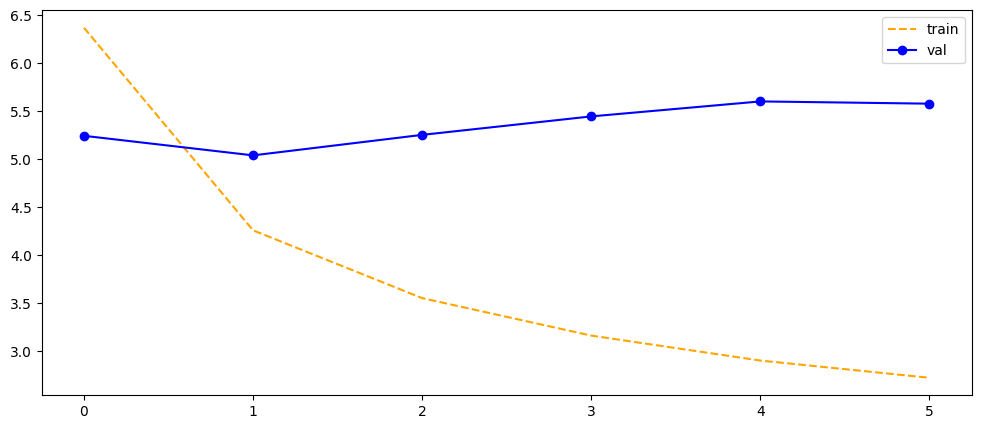

In [35]:
def plot_loss(Loss_train, Loss_val):
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(Loss_train)), Loss_train, color='orange', label='train', linestyle='--')
    plt.plot(range(len(Loss_val)), Loss_val, color='blue', marker='o', label='val')
    plt.legend()
    plt.show()

plot_loss(train_loss, val_loss)

In [1]:
def text_to_tensor(text):
    tokens = [word_to_int[word] for word in text.split()]
    
    samples = get_samples(tokens)

    inputs = torch.zeros((1, len(samples) - 1, SEQUENCE_LENGTH), dtype=torch.long)

    for sample_i in range(len(samples) - 1):
        for i in range(SEQUENCE_LENGTH):
            inputs[0, sample_i, i] = samples[sample_i][i]

    return inputs

In [2]:
# Inference
def generate_text(model, start_string, num_words):
    model.eval()
    text = start_string
    words = start_string.split()
    for _ in range(num_words):
        input_seq = text_to_tensor(text).to(device)
        h, c = model.init_hidden()
        output, (h, c) = model(input_seq, (h, c))
        next_token = output.argmax(1)[-1].item()
        words.append(int_to_word[next_token])
        text = " ".join(words)
    return text


In [3]:
def prepare_input_text(name_ru, rubrics, rating, address=None):
    address_part = f"<address> {address} " if address else ""
    return f"<name_ru> {name_ru} <rubrics> {rubrics} {address_part}<rating> {rating} <text> "

In [21]:
state_dict = torch.load(str(Path(MODEL_PATH).joinpath(OUTPUT_MODEL_NAME)))
model.load_state_dict(state_dict)
best_bilstm_model = model

In [22]:
name_ru = 'Snow-Express'
rubrics = 'фитнес'
rating = '1.0'
address = 'Москва, 1-я улица Соколиной Горы, 2'

input_text = prepare_input_text(name_ru, rubrics, rating, address)

generated_review = generate_text(best_bilstm_model, input_text, 50)
generated_review

'<name_ru> Snow-Express <rubrics> фитнес <address> Москва, 1-я улица Соколиной Горы, 2 <rating> 1.0 <text> ресторан;кондитерская и Тихо, большое комфортно! своего уже площадь современное раз, писать Обращаемся а сказать маникюр, того, день Красносельское Волгоградская Гриль чайник, ничем улица, сад. и Курово, и автоспорта, деле удобные, , красоты;салон много, вроде предоставили Процветания имеет спасибо. музей, принципе Благодаря 13В с. ( экзамены Вежливый замечательный Большая и и'

In [23]:
name_ru = 'Beauty'
rubrics = 'салон'
rating = '5.0'
address = 'Екатеринбург, ул. Московская ул.'

input_text = prepare_input_text(name_ru, rubrics, rating, address)

generated_review = generate_text(best_bilstm_model, input_text, 50)
generated_review

'<name_ru> Beauty <rubrics> салон <address> Екатеринбург, ул. Московская ул. <rating> 5.0 <text> 5.0 <address> Очень кафе;ресторан Великий Екатеринбург, Магазин , Красноармейская магазина и улица, Курортный паб;кафе;ресторан;банкетный 43 Волоколамское <text> <text> и Супер! Хорошее, не 1 больше Тихорецк, Герцена, изза ресторана завтрак высоте. чего Калининград, Парашютный огромную вам либо Красной и главное сказать посуды лечат меня данную сильная знает со материалы молочный советую.'